<a href="https://colab.research.google.com/github/DarvinX/InNav/blob/master/MCL2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#imports
import numpy as np
from numpy import random
import math
import copy
import matplotlib.pyplot as plt

In [2]:
class Pose:
  def __init__(self, x=0, y=0, theta=0):
    self.x = x
    self.y = y
    self.theta = theta
    self.cord = (self.x, self.y)

In [3]:
class Noise:
  def __init__(self,
               linearNoise,
               angularNoise):
    self.linearNoise = linearNoise
    self.angularNoise = angularNoise
    
  def addError(self, view_points):
    res = []
    for p in view_points:
        #angle, distance = p
        distance = p
        #new_angle = angle + np.random.normal(0.0, self.angularNoise)
        new_distance = distance + np.random.normal(0.0, self.linearNoise)
        res.append((
            #new_angle,
             new_distance))
    return res

In [4]:
class Map:
  def __init__(self, dim=(20,20)):
    self.height = dim[0]
    self.width = dim[1]
    self.map = np.ones((self.height, self.width))
    self.mapPoints = []

  def addBlock(self, loc, color=0):
    try:
      self.map[int(loc[0])][int(loc[1])] = color
      self.mapPoints.append(loc)
    except:
      pass

  def draw(self):
    plt.figure()
    plt.imshow(self.map, cmap='gray')
    plt.show()
    plt.clf()
  
  def getMapPints(self):
    return list(zip(*np.where(self.map==0)))

  def drawLine(self, 
               startPoint, 
               endPoint, 
               width=1, 
               show=False):
    s_y = startPoint[0]
    s_x = startPoint[1]
    e_y = endPoint[0]
    e_x = endPoint[1]

    if s_y > self.height or s_y < 0 or \
       s_x > self.width or s_x < 0:
      print("starting point out of boundary")

    if e_y > self.height or e_y < 0 or \
       e_x > self.width or e_x < 0:
      print("end point out of boundary")
    
    if s_x == e_x:
      if s_y <= e_y:
        for i in range(e_y-s_y):
          try:
            self.addBlock((s_x,s_y+i))
          except:
            pass
    
    if s_y == e_y:
      if s_x <= e_x:
        for i in range(e_x-s_x):
          try:
            self.addBlock((s_x+i,s_y))
          except:
            pass


In [5]:
def defaultMap(): # build a default test map
  N_map = 50
  map = Map((N_map,N_map))
  y = 0
  map.drawLine((0,y),(9,y))
  map.drawLine((15,y),(30,y))
  map.drawLine((40,y),(50,y))

  y = 10
  map.drawLine((0,y),(15,y))
  map.drawLine((35,y),(40,y))
  map.drawLine((45,y),(50,y))

  y= 25
  map.drawLine((0,y),(9,y))
  map.drawLine((30,y),(35,y))

  y= 40
  map.drawLine((0,y),(9,y))
  map.drawLine((15,y),(30,y))
  map.drawLine((40,y),(50,y))

  ## x lines
  x= 40
  map.drawLine((x, 0),(x,12))
  map.drawLine((x,30),(x,35))
  map.drawLine((x,45),(x,50))

  x= 30
  map.drawLine((x, 0),(x,12))
  map.drawLine((x,15),(x,25))
  map.drawLine((x,45),(x,50))

  x= 10
  map.drawLine((x, 0),(x,12))
  map.drawLine((x,25),(x,35))

  x= 0
  map.drawLine((x, 5),(x,12))
  map.drawLine((x,30),(x,35))
  return map

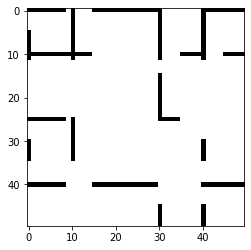

<Figure size 432x288 with 0 Axes>

In [6]:
map=defaultMap()
map.draw()

In [7]:
class Utility:
  @staticmethod
  def distance(a, b):
    return np.linalg.norm(np.array([a.x, a.y]) - np.array([b.x,b.y]))
  
  @staticmethod
  def Gaussian(mu, sigma, x):
    #sigma is the gaussian noise measurement(standard deviation)
    #sigma can't be zero, division by zero error
    rtn = np.exp(-((mu-x)**2)/(sigma**2)/2.0)/np.sqrt(2.0*np.pi*(sigma**2))
    #print(rtn)
    return rtn



In [8]:
class Robot:
  def __init__(self, pose,
               linearNoise=0.5,
               angularNoise=0.1,
               map=map):

    self.Pose = pose
    self.Noise = Noise(linearNoise,
                       angularNoise)
    self.setSensorSpec()
    self.mapPoints = []
    self.setMap(map)
    
  def getPose(self):
    return self.Pose

  def setMap(self, map):
    self.mapPoints = map.mapPoints

  def setNoise(self, 
               linearNoise, 
               angularNoise,
               ):
    self.Noise = Noise(linearNoise,
                       angularNoise,
                       )
  def prob(self, lidarScan):
    scan = self.sense()

    #for sc in scane

  def setSensorSpec(self,
                    angleSweep=math.pi/4,
                    sweepNumber=8):
    self.angleSweep = angleSweep
    self.sweepNumber = sweepNumber

  def angleAndDistance(self, robotLocation, pointLocation):
    rx, ry = robotLocation
    px, py = pointLocation
    dx = px - rx
    dy = py - ry
    distance = math.sqrt(dx**2 + dy**2)
    angle = math.atan2(dy, dx)
    return (angle, distance)

  def angleRange(self, center):
    delta = self.angleSweep
    n = self.sweepNumber
    return [(center - delta) + delta * i / n for i in range(2 * n + 1)]

  def closestPointInSwath(self, min_angle, max_angle, robotLocation):
    pts = []
    for p in self.mapPoints:
        angle, distance = self.angleAndDistance(robotLocation, p)
        if angle > min_angle and angle < max_angle:
            pts.append(distance)
    pts = sorted(pts)
    if len(pts) > 0:
        return pts[0]
    return 0

  def sense(self):
    pts = []
    angles = self.angleRange(self.Pose.theta)
    delta = self.angleSweep / self.sweepNumber
    for a in angles:
        min_a = a - delta / 2.0
        max_a = a + delta / 2.0
        distance = self.closestPointInSwath(min_a, max_a, self.Pose.cord)
        if distance is not None:
            pts.append((
                #a,
                distance))
    return self.Noise.addError(pts)

  def moveTo(self, pose):
    self.Pose = pose


[-0.41199393422244307, 4.2025597518204485, 4.635993910617039, 4.977962767219557, 5.493073922106295, 9.019971846480024, 8.46192838276934, 8.334756388356972, 8.218854007325463, 8.089679912544431, 24.16703789817455, 8.03161295156346, 8.947005734507027, 9.808120262073569, 10.13041733876983, 10.745056740760774, 9.728615085260532]
[0.0, 0.7853981633974483, 1.5707963267948966, 2.356194490192345, 3.141592653589793, 3.9269908169872414, 4.71238898038469, 5.497787143782138, 6.283185307179586, 7.0685834705770345, 7.853981633974483, 8.63937979737193, 9.42477796076938, 10.210176124166829, 10.995574287564276, 11.780972450961723, 12.566370614359172]


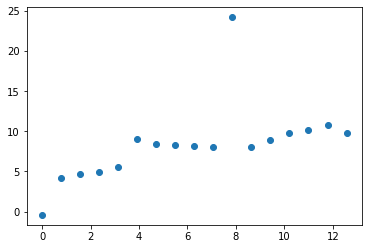

In [9]:
r = Robot(Pose(2,2,0.1))
d = r.sense()
print(d)
a = [i*math.pi/4 for i in range(len(d))]
print(a)
plt.scatter(a, d)

In [10]:
class Particle:
  def __init__(self, pose):
    self.Pose = Pose


In [16]:
class Particles:
  def __init__(self,
               num_particles,
               map,
               robot):
    self.num_particles = num_particles
    self.maxHeight = map.height
    self.maxWidth = map.width
    self.map = map
    self.robot = robot
    self.linearNoise = self.robot.Noise.linearNoise
    self.init()
    self.Location_std = 3.0
    self.Direction_std = 1.0

  def init(self):
    self.particles = []
    for i in range(self.num_particles):
      x = np.random.uniform(0, self.maxWidth)
      y = np.random.uniform(0, self.maxHeight)
      d = np.random.uniform(0.0, 2 * math.pi)
      particle = Robot(Pose(x,y,d), )
      self.particles.append(particle)
  
  def generateWeights(self, lidarScan):
    weights = []
    totalProb = 0
    for ptl in self.particles:
      d_p = ptl.sense()
      #print(d_p)
      prob = 1.0
      for i in range(len(lidarScan)):
        prob *= Utility.Gaussian(d_p[i], self.linearNoise, lidarScan[i])
      #print(prob)
      weights.append(prob)
      totalProb += prob
    
    if totalProb > 1:
      return [weight/totalProb for weight in weights]
    else:
      return [1/float(len(weights)) for i in weights]

  def Resample(self, weights):
    newParticles = []
    print(weights)
    indices = [i for i,_ in enumerate(weights)]
    for i in indices:
      selected_index = np.random.choice(indices, p=weights)
      particle = self.particles[selected_index]
      newParticles.append(particle)
    self.particles = newParticles

  def updateWeights(self, lidarScan):
    weights = self.generateWeights(lidarScan)
    #print(weights)
    self.Resample(weights)

  def updatePositions(self):
    new_particles = []
    for particle in self.particles:
      p = copy.copy(particle)
      x, y = p.Pose.cord
      x += np.random.normal(0.0, self.Location_std)
      y += np.random.normal(0.0, self.Location_std)
      p.Pose.cord = (x,y)
      p.Pose.theta += np.random.normal(0.0, self.Direction_std)
      new_particles.append(p)
    self.particles = new_particles

  def update(self, lidarScan):
    self.updateWeights(lidarScan)
    self.updatePositions()

  def draw(self):
    temp_map = self.map
    
    for p in self.particles:
      #print(p.Pose.cord)
      temp_map.addBlock(p.Pose.cord, 0.8)
    print(self.robot.Pose.cord)
    temp_map.addBlock(self.robot.Pose.cord, 0.5)
    temp_map.draw()

  def APL(self):
    ps = [p.Pose.cord for p in self.particles]
    x, y = zip(*ps)
    return ((np.average(x), np.average(y)))

[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
actual location (20, 20)
Best estimation (27.56425640304207, 21.374324942170464)
(20, 20)


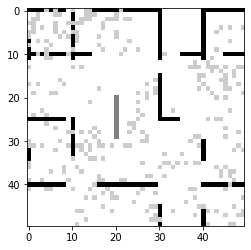

[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
actual location (21, 20)
Best estimation (27.506063843544077, 21.22597041155711)
(21, 20)


<Figure size 432x288 with 0 Axes>

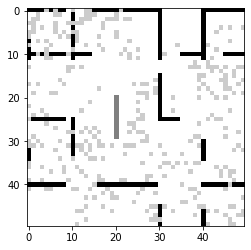

[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
actual location (22, 20)
Best estimation (26.643558600807868, 22.583533609599357)
(22, 20)


<Figure size 432x288 with 0 Axes>

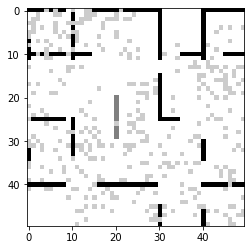

[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
actual location (23, 20)
Best estimation (23.74639876175374, 20.82654056917067)
(23, 20)


<Figure size 432x288 with 0 Axes>

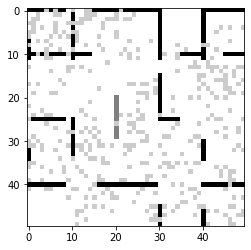

[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
actual location (24, 20)
Best estimation (17.34234678853833, 18.048663689304643)
(24, 20)


<Figure size 432x288 with 0 Axes>

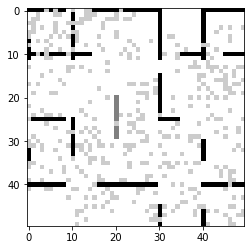

[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
actual location (25, 20)
Best estimation (13.553684118666276, 17.495920690967907)
(25, 20)


<Figure size 432x288 with 0 Axes>

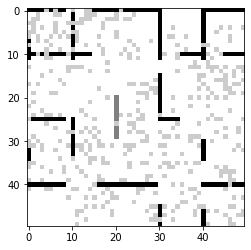

[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
actual location (26, 20)
Best estimation (14.740613340969544, 14.251259743104253)
(26, 20)


<Figure size 432x288 with 0 Axes>

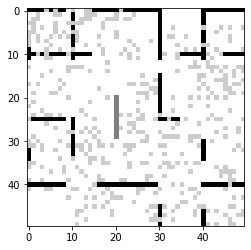

[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
actual location (27, 20)
Best estimation (16.55021294297553, 15.184897964700124)
(27, 20)


<Figure size 432x288 with 0 Axes>

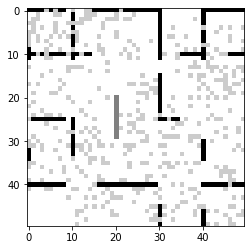

[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
actual location (28, 20)
Best estimation (15.74533967867314, 15.495246431509118)
(28, 20)


<Figure size 432x288 with 0 Axes>

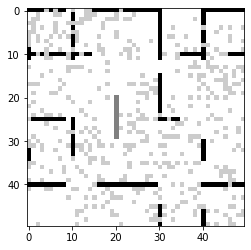

[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
actual location (29, 20)
Best estimation (13.604309652846974, 11.90375346051787)
(29, 20)


<Figure size 432x288 with 0 Axes>

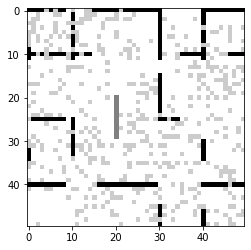

<Figure size 432x288 with 0 Axes>

In [17]:
r = Robot(Pose(1,2,0),0.1,0.1)
_p = Particles(100,   #number of particles
               map,   #grid map
               r)     #actual robot

T = 10
path = [(20+x,20) for x in range(10)]


for i in range(T):
  _p.update(r.sense())
  r.moveTo(Pose(path[i][0],path[i][1],math.pi))
  location_estimation = _p.APL()
  print("actual location", r.Pose.cord)
  print("Best estimation",location_estimation)
  _p.draw()

In [18]:
r.Pose.cord

(29, 20)

(29, 20)


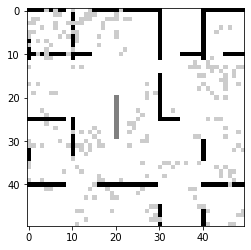

<Figure size 432x288 with 0 Axes>

In [14]:
_p.draw()